# Preprocessing CITE-seq integrated PBMC dataset
The following notbook creates two datasets from the [PBMC dataset](https://atlas.fredhutch.org/nygc/multimodal-pbmc/). The first only containing Monocytes, B and NK cells. The second contains B-cell subtypes. We follow the preprocessing steps of the book "Single-cell best practices" [1], and use the shift logarithm for namalization described by Ahlmann-Eltze and Huber [2] and implemented in this Tweet [3]. 

[1] Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet (2023). https://doi.org/10.1038/s41576-023-00586-w

[2] Ahlmann-Eltze, C., Huber, W. Comparison of transformations for single-cell RNA-seq data. Nat Methods (2023). https://doi.org/10.1038/s41592-023-01814-1

[3] https://twitter.com/Sanbomics/status/1647654042749874177?s=20

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import os
import scanpy as sc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import diags
from scipy.stats import median_abs_deviation

from constants import BASE_PATH_DATA

## Helper functions

In [3]:
def shifted_transformation(adata, y0=1):
    """
    From Twitter post https://twitter.com/Sanbomics/status/1647654042749874177?s=20
    Refering to publication by Ahlmann-Eltze & Huber.
    
    Ahlmann-Eltze, C., Huber, W. Comparison of transformations for single-cell RNA-seq data. 
    Nat Methods (2023). https://doi.org/10.1038/s41592-023-01814-1
    """
    target_sum = np.mean(adata.X.sum(axis=1))
    print(f'Mean shift logarithm normalization with normalization target count {target_sum}')
    size_factors = adata.X.sum(axis=1) / target_sum
    
    adata.X = diags(1 / size_factors.A1).dot(adata.X)
    adata.X.data = np.log(adata.X.data + y0)
    adata.uns["log1p"] = {"base": None}
    return adata


def is_outlier(adata, metric: str, nmads: int):
    """
    The method is taken from the tutorial https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#filtering-low-quality-reads
    
    Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet (2023). https://doi.org/10.1038/s41576-023-00586-w
    """
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier


def filter_low_quality_reads(adata, 
                             mad_tot_cnt=5, 
                             mad_ngenes_cnt=5, 
                             nr_top_genes=20,
                             mad_pct_cnt_top_genes=5, 
                             mad_pct_mt=3, 
                             min_pct_mt=8):
    """
    The method is taken from the tutorial https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html#filtering-low-quality-reads
    
    Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. 
    Nat Rev Genet (2023). https://doi.org/10.1038/s41576-023-00586-w
    """
    if 'mt' not in adata.var:
        # get mitochondrial genes
        adata.var["mt"] = adata.var_names.str.startswith("MT-")
    if 'ribo' not in adata.var:         
        # get ribosomal genes
        adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    if 'hb' not in adata.var:
        # get hemoglobin genes.
        adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    
    # compute the quality control metrics
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[nr_top_genes], log1p=True)    
    
    adata.obs["outlier"] = (is_outlier(adata, "log1p_total_counts", mad_tot_cnt)
                            | is_outlier(adata, "log1p_n_genes_by_counts", mad_ngenes_cnt)
                            | is_outlier(adata, f"pct_counts_in_top_{nr_top_genes}_genes", mad_pct_cnt_top_genes)
                           )
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", mad_pct_mt) | (adata.obs["pct_counts_mt"] > min_pct_mt)
    
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    return adata


def filtercells(adata, sample_col='orig.ident', params_cell_filtering={}):
    """
    Filter loww quality reads per sample as suggested by Heumos et al. 
    
    Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. 
    Nat Rev Genet (2023). https://doi.org/10.1038/s41576-023-00586-w
    """ 
    nr_cells_orig = adata.shape[0]
    adatas = {}
    for (sid, sample_data) in adata.obs.groupby(sample_col):
        adatas[sid] = adata[sample_data.index,].copy()
    for key, curr_adata in adatas.items():
        adatas[key] = filter_low_quality_reads(curr_adata, **params_cell_filtering)
    adata = sc.concat(list(adatas.values()), join='outer', merge='same')
    nr_cells_filt = adata.shape[0]
    print(f'Filtering {(nr_cells_orig-nr_cells_filt)} of {nr_cells_orig} low quality cells'
          f'({np.round((nr_cells_orig-nr_cells_filt)/nr_cells_orig *100, decimals=2)}%).')
    return adata

def filtergenes(adata, pct=0.01):
    """
    Remove genes that are not present in at least 1% of all cells. We do the same as it was done in CanSig. 
    
    CanSig: Discovering de novo shared transcriptional programs in single cancer cells
    Josephine Yates, Florian Barkmann, Paweł Czyż, Marc Glettig, Frederieke Lohmann, 
    Richard von der Horst, Elia Saquand, Nicolas Volken, Agnieszka Kraft, Valentina Boeva, 
    bioRxiv 2022.04.14.488324; doi: https://doi.org/10.1101/2022.04.14.488324 
    """
    nr_cells, nr_genes = adata.shape    
    gene_expr_in_cells_cnts = adata.X.getnnz(axis=0)
    enough_genes  = gene_expr_in_cells_cnts - nr_cells * pct
    print(f'Filtering {np.sum(enough_genes < 0)} of {nr_genes} genes'
          f'({np.round((np.sum(enough_genes < 0))/nr_genes *100, decimals=2)}%).')
    adata = adata[:, enough_genes >= 0].copy()
    return adata


def preprocess_dataset(adata, filter_cells=True, filter_genes=True, shift_method='mean', params_cell_filtering={}, sample_based=False, sample_col='orig.ident'):   
    #CREATE PLOT
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)    
    sns.histplot(adata.obs["total_counts"], bins=100, kde=False)
    # sc.pl.violin(adata, 'total_counts')
    sc.pl.violin(adata, "pct_counts_mt")
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    
    # FILTER CELLS
    if filter_cells:
        adata = filtercells(adata,params_cell_filtering=params_cell_filtering)
    
    #CREATE PLOT  
    sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True)    
    sns.histplot(adata.obs["total_counts"], bins=100, kde=False)
    # sc.pl.violin(adata, 'total_counts')
    sc.pl.violin(adata, "pct_counts_mt")
    sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")
    
    # FILTER GENES
    if filter_genes:
        adata = filtergenes(adata)
    
    adata.layers["counts"] = adata.X
    
    # FILTER NORMALIZE
    if shift_method == 'median':
        sc.pp.normalize_total(adata)
        sc.pp.log1p(adata)
        adata.uns['log1p']['base'] = None
    elif shift_method == 'mean':
        adata = shifted_transformation(adata)
    elif shift_method == 'CP10k':
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)
        adata.uns['log1p']['base'] = None
    else:
        raise ValueError('Unknown shift transformation method! Can choose between mean, median and CP10k.')
    
    return adata

## Preprocessing

In [4]:
fn_data = os.path.join(BASE_PATH_DATA, 'raw_data/pbmc_citeseq.h5ad')

In [5]:
adata = sc.read_h5ad(fn_data)

/Users/lciernik/miniforge3/envs/ans_scoring/lib/python3.9/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


In [6]:
adata = adata.raw.to_adata()
adata.var_names = adata.var['_index']
adata.var_names.name = None
adata.var.columns = ['gene_names']

In [7]:
if 'mt' not in adata.var:
    # get mitochondrial genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
if 'ribo' not in adata.var:         
    # get ribosomal genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
if 'hb' not in adata.var:
    # get hemoglobin genes.
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [8]:
adata

AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'gene_names', 'mt', 'ribo', 'hb'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    obsp: 'distances'

In [13]:
l1_adata = adata[adata.obs['celltype.l1'].isin(['B', 'NK', 'Mono'])].copy()
l2_adata = adata[adata.obs['celltype.l2'].str.contains('B ')].copy()
l3_adata = adata[adata.obs['celltype.l1'] == 'CD4 T'].copy()
l4_adata = adata[adata.obs['celltype.l1'] == 'CD8 T'].copy()
l5_adata = adata.copy()

### Global variables 

In [10]:
norm_method='mean' # alternatives '' for mean and 'median' for median 
sample_based=False # alternatives False for computation on entire dataset 

if norm_method=='median':
    appendix = '_med_per_sid' if sample_based else '_med'
elif norm_method=='CP10k':
    appendix = '_cp10k_per_sid' if sample_based else '_cp10k'
else:
    appendix = '_per_sid' if sample_based else ''
    
print(appendix)

### Preprocess Monocytes, B and NK cells dataset

In [ ]:
fn_out_l1_data= os.path.join(BASE_PATH_DATA, f'preprocessed/pp_pbmc_b_mono_nk{appendix}.h5ad')

In [ ]:
l1_adata.obs['celltype.l1'].value_counts().sort_index()

In [ ]:
l1_adata

In [ ]:
l1_adata = preprocess_dataset(l1_adata,
                              shift_method = norm_method, 
                              params_cell_filtering=dict(mad_tot_cnt=5, 
                                                         mad_ngenes_cnt=5, 
                                                         nr_top_genes=20,
                                                         mad_pct_cnt_top_genes=5,
                                                         mad_pct_mt=5,
                                                         min_pct_mt=9))

In [ ]:
l1_adata.write(fn_out_l1_data)

### Preprocess B-cell subtypes dataset

In [ ]:
fn_out_l2_data= os.path.join(BASE_PATH_DATA, f'preprocessed/pp_pbmc_b_subtypes{appendix}.h5ad')

In [ ]:
l2_adata.obs['celltype.l2'].value_counts().sort_index()

In [ ]:
l2_adata

In [ ]:
l2_adata = preprocess_dataset(l2_adata, 
                              shift_method = norm_method,
                              params_cell_filtering=dict(mad_tot_cnt=5, 
                                                         mad_ngenes_cnt=5, 
                                                         nr_top_genes=20,
                                                         mad_pct_cnt_top_genes=5,
                                                         mad_pct_mt=5,
                                                         min_pct_mt=9))

In [ ]:
l2_adata

In [ ]:
l2_adata.obs['celltype.l2'].value_counts().sort_index()

In [ ]:
l2_adata.write(fn_out_l2_data)

### Preprocess CD4 T-cell subtypes dataset

In [ ]:
fn_out_l3_data= os.path.join(BASE_PATH_DATA, f'preprocessed/pp_pbmc_cd4_subtypes{appendix}.h5ad')

In [ ]:
l3_adata.obs['celltype.l2'].value_counts().sort_index()

In [ ]:
l3_adata

In [ ]:
l3_adata = preprocess_dataset(l3_adata, 
                              shift_method = norm_method,
                              params_cell_filtering=dict(mad_tot_cnt=5, 
                                                         mad_ngenes_cnt=5, 
                                                         nr_top_genes=20,
                                                         mad_pct_cnt_top_genes=5,
                                                         mad_pct_mt=5,
                                                         min_pct_mt=9))

In [ ]:
l3_adata

In [ ]:
l3_adata.obs['celltype.l2'].value_counts().sort_index()

In [ ]:
l3_adata.write(fn_out_l3_data)

### Preprocess CD8 T-cell subtypes dataset

In [ ]:
fn_out_l4_data= os.path.join(BASE_PATH_DATA, f'preprocessed/pp_pbmc_cd8_subtypes{appendix}.h5ad')

In [ ]:
l4_adata.obs['celltype.l2'].value_counts().sort_index()

In [ ]:
l4_adata

In [ ]:
l4_adata = preprocess_dataset(l4_adata, 
                              shift_method = norm_method,
                              params_cell_filtering=dict(mad_tot_cnt=5, 
                                                         mad_ngenes_cnt=5, 
                                                         nr_top_genes=20,
                                                         mad_pct_cnt_top_genes=5,
                                                         mad_pct_mt=5,
                                                         min_pct_mt=9))

In [ ]:
l4_adata

In [ ]:
l4_adata.obs['celltype.l2'].value_counts().sort_index()

In [ ]:
l4_adata.write(fn_out_l4_data)

### Preprocess CD8 T-cell subtypes dataset

In [14]:
fn_out_l5_data= os.path.join(BASE_PATH_DATA, f'preprocessed/pp_pbmc{appendix}.h5ad')

In [15]:
l5_adata.obs['celltype.l2'].value_counts().sort_index()

ASDC                    76
B intermediate        2431
B memory              3285
B naive               7718
CD14 Mono            42690
CD16 Mono             6320
CD4 CTL               1736
CD4 Naive            17479
CD4 Proliferating      108
CD4 TCM              14889
CD4 TEM               4282
CD8 Naive            10768
CD8 Proliferating       91
CD8 TCM               2883
CD8 TEM              11727
Doublet                605
Eryth                   83
HSPC                   329
ILC                    132
MAIT                  2784
NK                   17173
NK Proliferating       548
NK_CD56bright          943
Plasmablast            366
Platelet              2293
Treg                  2507
cDC1                   151
cDC2                  2501
dnT                    356
gdT                   3649
pDC                    861
Name: celltype.l2, dtype: int64

In [16]:
l5_adata

AnnData object with n_obs × n_vars = 25469 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT'
    var: 'gene_names', 'mt', 'ribo', 'hb'
    uns: 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    obsp: 'distances'

/Users/lciernik/miniforge3/envs/ans_scoring/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


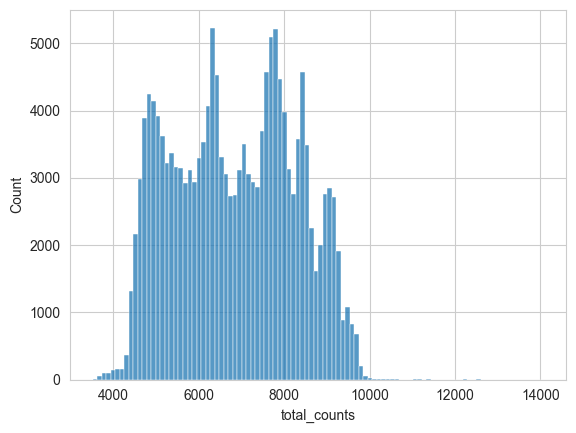

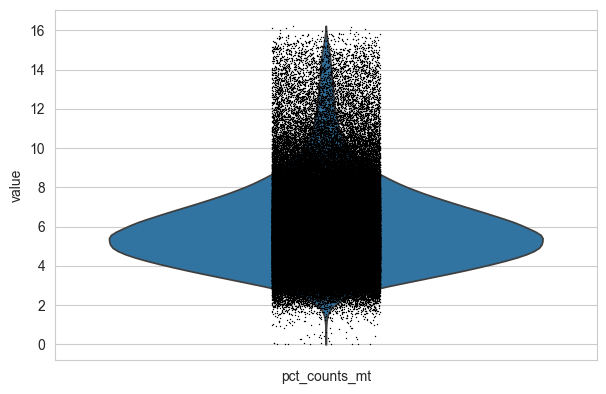

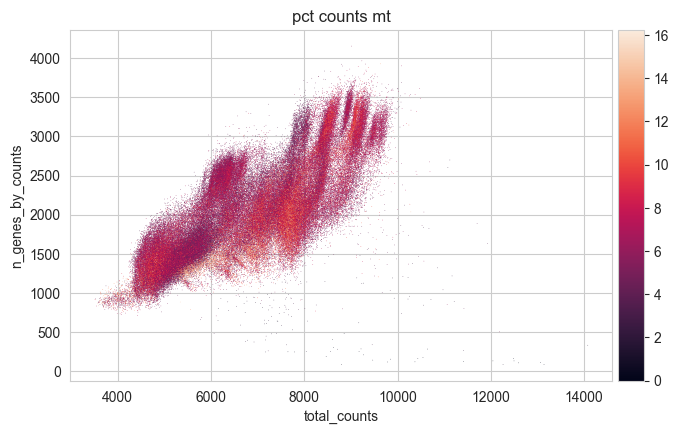

Filtering 14090 of 161764 low quality cells(8.71%).


/Users/lciernik/miniforge3/envs/ans_scoring/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


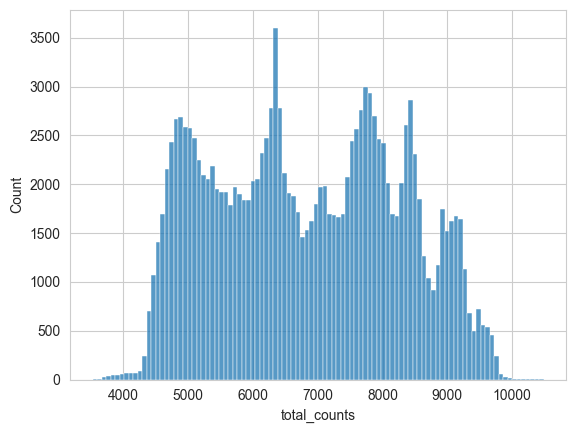

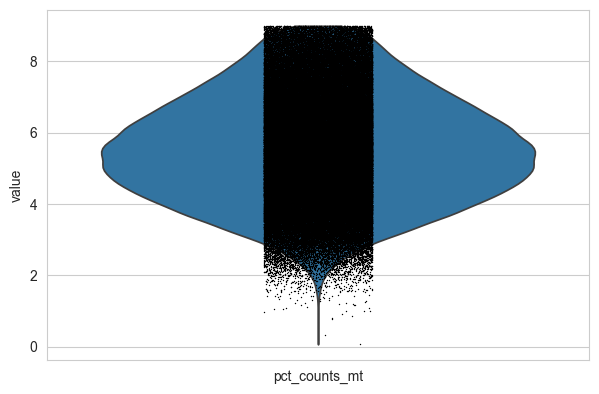

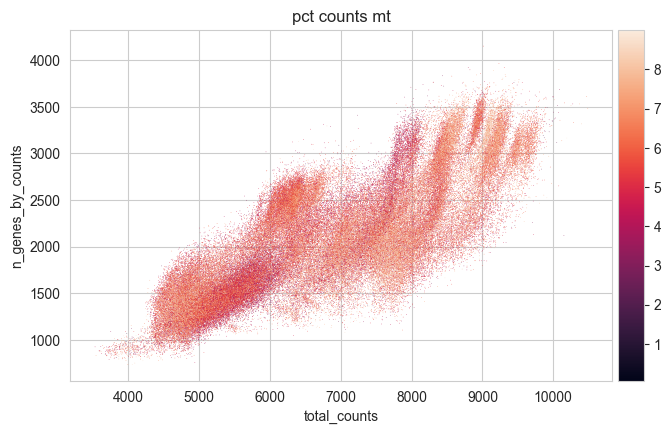

Filtering 8725 of 20729 genes(42.09%).
Mean shift logarithm normalization with normalization target count 6812.2570594688295


In [17]:
l5_adata = preprocess_dataset(l5_adata, 
                              shift_method = norm_method,
                              params_cell_filtering=dict(mad_tot_cnt=5, 
                                                         mad_ngenes_cnt=5, 
                                                         nr_top_genes=20,
                                                         mad_pct_cnt_top_genes=5,
                                                         mad_pct_mt=5,
                                                         min_pct_mt=9))

In [18]:
l5_adata

AnnData object with n_obs × n_vars = 147674 × 12004
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_names', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    layers: 'counts'

In [19]:
l5_adata.obs['celltype.l2'].value_counts().sort_index()

ASDC                    74
B intermediate        2090
B memory              2982
B naive               6507
CD4 CTL               1603
CD4 Naive            17336
CD4 Proliferating       82
CD4 TCM              14415
CD4 TEM               4024
CD8 Naive            10394
CD8 Proliferating       76
CD8 TCM               2749
CD8 TEM               9956
CD14 Mono            38607
CD16 Mono             5842
Doublet                541
Eryth                    2
HSPC                   321
ILC                    124
MAIT                  2426
NK                   15322
NK Proliferating       499
NK_CD56bright          860
Plasmablast             44
Platelet              1680
Treg                  2483
cDC1                   150
cDC2                  2402
dnT                    335
gdT                   2907
pDC                    841
Name: celltype.l2, dtype: int64

In [20]:
l5_adata.write(fn_out_l5_data)